# Training a simple CNN model in Tensorflow for Tornado Detection

This notebook steps through how to train a simple CNN model using a subset of TorNet.

This will not produce a model with any skill, but simply provides a working end-to-end example of how to set up a data loader, build, and fit a model


In [1]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES
import tornet.data.preprocess as pp
from tornet.data import preprocess as tfpp
import keras
from tornet.data.constants import CHANNEL_MIN_MAX
import tornet.metrics.keras.metrics as km

In [42]:
# Create basic dataloader
# This option loads directly from netcdf files, and will be slow and IO bound
# To speed up training, either
#     build as a tensorflow_dataset , (see tornet/data/tfds/tornet/README.md)
#     cache dataset first , or
#     use tf.data.Dataset.load on a pre-saved dataset

# Location of tornet
data_root = "C:/Users/mjhig/tornet_2013"

# Get training data from 2018
data_type='train'
years = [2013, 2014,2015,2016,2017,2018]
catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1,random_state=1234)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds = create_tf_dataset(file_list,variables=ALL_VARIABLES) 

# (Optional) Save data for faster reloads (makes copy of data!)
# ds.save('tornet_sample.tfdataset') 


In [44]:
# Build a test set
# Basic loader
data_type='test'
years = [2013, 2014,2015,2016,2017,2018]

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1,random_state=1234)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds_test = create_tf_dataset(file_list,variables=ALL_VARIABLES) 


KeyboardInterrupt: 

In [45]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load and preprocess dataset
data_root = "C:/Users/mjhig/tornet_2013"
data_type = 'train'
years = [2013, 2014,2015,2016,2017,2018]


catalog_path = os.path.join(data_root, 'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at ' + data_root)

catalog = pd.read_csv(catalog_path, parse_dates=['start_time', 'end_time'])
catalog = catalog[catalog['type'] == data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1, random_state=1234)
file_list = [os.path.join(data_root, f) for f in catalog.filename]

# Create dataset
ds = create_tf_dataset(file_list, variables=ALL_VARIABLES)

# Preprocessing pipeline
ds = ds.map(lambda d: pp.add_coordinates(d, include_az=False, backend=tf))
ds = ds.map(pp.remove_time_dim)
ds = ds.map(tfpp.split_x_y)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds = ds.batch(32)

# Define reusable components
def create_model(architecture):
    """Create a CNN model with different architectures."""
    inputs = {v: keras.Input(shape=(120, 240, 2), name=v) for v in ALL_VARIABLES}
    norm_layers = []
    for v in ALL_VARIABLES:
        min_max = np.array(CHANNEL_MIN_MAX[v])
        var = ((min_max[1] - min_max[0]) / 2) ** 2
        var = np.array(2 * [var])
        offset = (min_max[0] + min_max[1]) / 2
        offset = np.array(2 * [offset])
        norm_layers.append(
            keras.layers.Normalization(mean=offset, variance=var, name=f'Normalized_{v}')
        )
    x = keras.layers.Concatenate(axis=-1, name='Concatenate1')(
        [l(inputs[v]) for l, v in zip(norm_layers, ALL_VARIABLES)]
    )
    x = keras.layers.Lambda(lambda x: tf.where(tf.math.is_nan(x), -3.0, x), name='ReplaceNan')(x)
    
    if architecture == "baseline":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "deeper":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "residual":
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x= keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "wide":
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    elif architecture == "dropout":
        x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', name='TornadoLikelihood')(x)
    else:
        raise ValueError("Unknown architecture type")
    
    y = keras.layers.GlobalMaxPool2D(name='GlobalMaxPool')(x)
    return keras.Model(inputs=inputs, outputs=y, name=f'TornadoDetector_{architecture}')

# Train and evaluate different models
architectures = ["baseline", "deeper", "residual", "wide", "dropout"]
results = {}

model = create_model("dropout")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(from_logits=True))
model.fit(ds, epochs=4, steps_per_epoch=10)



Epoch 1/4


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 4.0146
Epoch 2/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 1.3025
Epoch 3/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.9358
Epoch 4/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.7791


In [6]:
# preprocess
ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)


In [29]:
# Evaluate
import tornet.metrics.keras.metrics as km
metrics = [keras.metrics.AUC(from_logits=True,name='AUC'),
           km.BinaryAccuracy(from_logits=True,name='BinaryAccuracy'), 
           ]
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=metrics)

# steps=10 for demo purposes
model.evaluate(ds_test,steps=10)

c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.5053 - BinaryAccuracy: 0.8407 - loss: 0.6967


[0.6962376236915588, 0.5143358707427979, 0.871874988079071]

In [46]:
def make_gradcam_heatmap_with_input_gradients(model_inputs, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        tape.watch(model_inputs)  # Watch the inputs to compute gradients
        conv_outputs, predictions = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients with respect to the inputs
    input_grads = tape.gradient(class_channel, model_inputs)

    # Gradients with respect to the last conv layer
    conv_grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize heatmap to [0, 1]

    return np.array(heatmap), input_grads


In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap_with_input_gradients(model_inputs, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_inputs)  # Watch the inputs to compute gradients
        conv_outputs, predictions = grad_model(model_inputs)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients with respect to the inputs
    input_grads = tape.gradient(class_channel, model_inputs)

    # Gradients with respect to the last conv layer
    conv_grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1, 2))  # Average gradients over width and height
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Sum across channels

    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)  # Normalize heatmap to [0, 1]

    return np.array(heatmap), input_grads




# Unpack the dataset
for sample in ds_test.take(1):  # Take a single batch from the dataset
    inputs, _ = sample  # Assuming the dataset is structured as (features, labels)
    break

# Prepare the list of inputs for the model
model_inputs = [
    inputs['DBZ'], 
    inputs['VEL'], 
    inputs['KDP'], 
    inputs['RHOHV'], 
    inputs['ZDR'], 
    inputs['WIDTH']
]

# Generate heatmap and input gradients
heatmap, input_grads = make_gradcam_heatmap_with_input_gradients(model_inputs, model, 'TornadoLikelihood')

# Calculate the importance of each input
input_importance = [tf.reduce_mean(tf.abs(grad)).numpy() for grad in input_grads]

# Map input names to their importance
input_names = ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']
input_importance_dict = dict(zip(input_names, input_importance))

# Print or plot the importance of each input
print("Input importance:", input_importance_dict)


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['DBZ', 'KDP', 'RHOHV', 'VEL', 'WIDTH', 'ZDR']]. Received: the structure of inputs=['*', '*', '*', '*', '*', '*']
  warnings.warn(


Input importance: {'DBZ': 3.930369e-07, 'VEL': 5.159255e-06, 'KDP': 3.0089139e-05, 'RHOHV': 2.5846273e-07, 'ZDR': 4.461667e-06, 'WIDTH': 5.2807604e-06}


In [ ]:
p

Most important regions for DBZ:
Shape of importance map: (120, 240)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

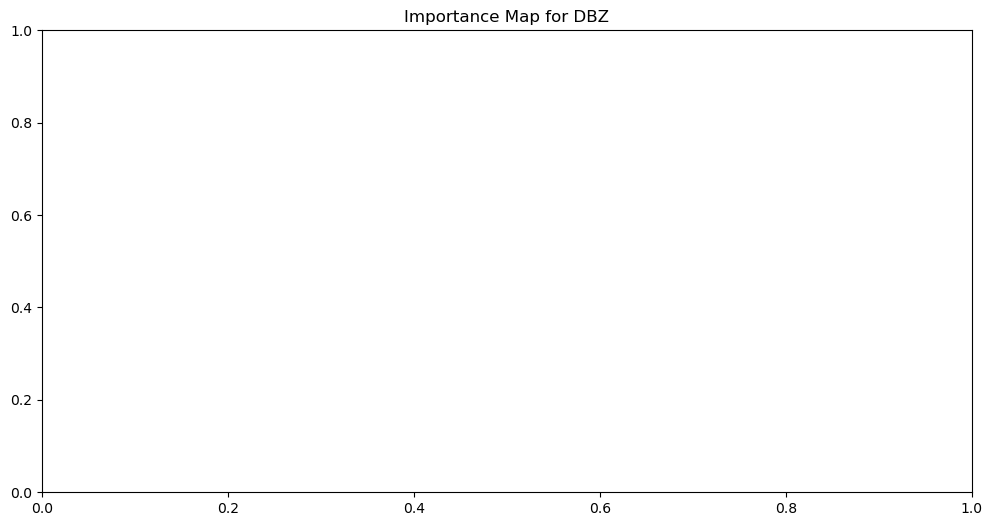

: 

In [ ]:
from tornet.display.display import plot_radar


# Analyze each input slice
for i, grad in enumerate(input_grads):
    input_name = input_names[i]

    # Compute mean absolute gradient for each spatial location
    grad_abs_mean = tf.reduce_mean(tf.abs(grad), axis=-1).numpy()  # Shape: (batch_size, height, width)

    # Select the most important regions for the first sample in the batch
    important_regions = grad_abs_mean[0]  # First sample in batch

    print(f"Most important regions for {input_name}:")
    print("Shape of importance map:", important_regions.shape)

    # Visualize the importance map
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plt.title(f"Importance Map for {input_name}")
    plot_radar(data=important_regions,fig=fig,channels=ALL_VARIABLES)
    #plt.imshow(important_regions, cmap="hot")
    plt.colorbar(label="Importance")
    plt.show()
